In [1]:
%cd "/home/albin/skolarbete/DML_LAsegmentation"

/home/albin/skolarbete/DML_LAsegmentation


In [2]:
from scripts.train import train, validate, patched_forward
from scripts.utils import CombinedLoss
from models.unet import UNet3D
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.dataset import TrainDataset, TestDataset

In [3]:
train_image_path = 'data/Task02_Heart/imagesTr'
train_label_path = 'data/Task02_Heart/labelsTr'
val_image_path = 'data/Task02_Heart/imagesVl'
val_label_path = 'data/Task02_Heart/labelsVl'

patch_size = (64, 64, 64)
train_dataset = TrainDataset(train_image_path, train_label_path, patch_size, require_target=True)
val_dataset = TestDataset(val_image_path, val_label_path)

batch_size = 20
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [4]:
model = UNet3D(in_channels=1, out_channels=1, features=[32, 64, 128, 256])
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = CombinedLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 500

results = train(model, optimizer, loss_fn, train_loader, val_loader, None, device, epochs, patch_size=patch_size, validation_freq=50)

Starting training on device cuda...


/home/albin/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv3d(


Epoch 1 of 500 took 3.07s | Training: loss=0.8069, iou=0.0424, dice=0.0260
Epoch 2 of 500 took 2.13s | Training: loss=0.7360, iou=0.0058, dice=0.0082
Epoch 3 of 500 took 2.12s | Training: loss=0.8394, iou=0.0561, dice=0.1232
Epoch 4 of 500 took 2.00s | Training: loss=0.8351, iou=0.0456, dice=0.1311
Epoch 5 of 500 took 1.87s | Training: loss=0.8426, iou=0.0433, dice=0.1473
Epoch 6 of 500 took 1.85s | Training: loss=0.9512, iou=0.0816, dice=0.2747
Epoch 7 of 500 took 1.83s | Training: loss=0.8176, iou=0.0342, dice=0.1303
Epoch 8 of 500 took 1.80s | Training: loss=0.8792, iou=0.0534, dice=0.2122
Epoch 9 of 500 took 1.82s | Training: loss=0.8267, iou=0.0355, dice=0.1614
Epoch 10 of 500 took 1.85s | Training: loss=0.8428, iou=0.0424, dice=0.1907
Epoch 11 of 500 took 1.90s | Training: loss=0.9359, iou=0.0664, dice=0.3030
Epoch 12 of 500 took 1.96s | Training: loss=0.8891, iou=0.0582, dice=0.2524
Epoch 13 of 500 took 1.83s | Training: loss=0.8751, iou=0.0529, dice=0.2528
Epoch 14 of 500 took 

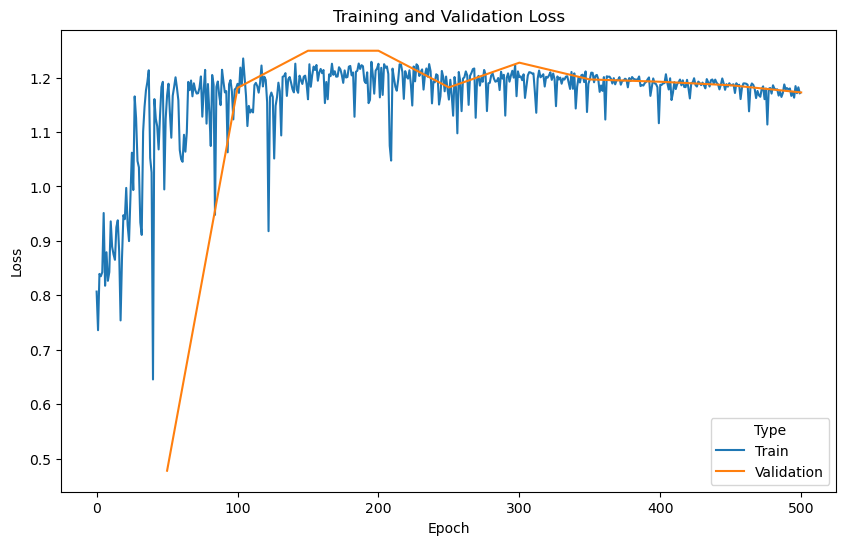

In [5]:
results_train, results_val = results

# Create a DataFrame for easier plotting with Seaborn
df_train = pd.DataFrame({'Epoch': range(len(results_train['loss'])), 'Loss': results_train['loss'], 'Type': 'Train'})
df_val = pd.DataFrame({'Epoch': [50 * (1 + x) for x in range(len(results_val['loss']))], 'Loss': results_val['loss'], 'Type': 'Validation'})

# Combine the DataFrames
df = pd.concat([df_train, df_val])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epoch', y='Loss', hue='Type')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Visualize an example of the selection for a trained image

In [6]:
image, label = val_dataset[0]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    pred_logits = patched_forward(model, image, patch_size, 'cuda')
pred = torch.sigmoid(pred_logits)
pred = pred.squeeze(0, 1)
image = image.squeeze(0, 1)

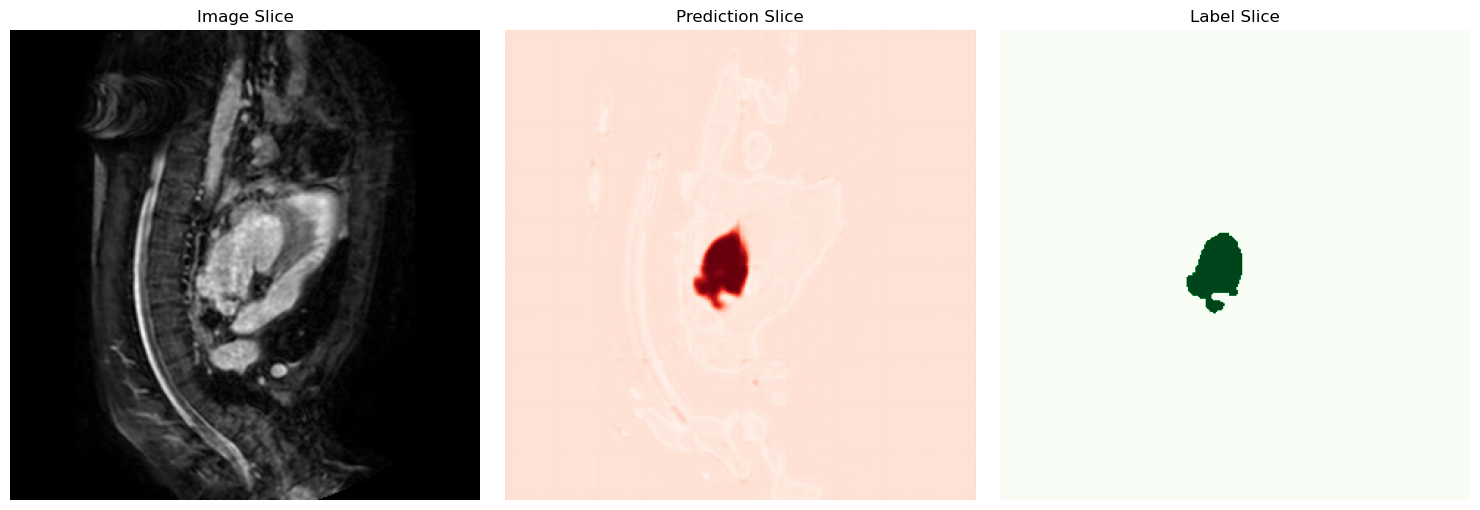

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 50
image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

# Create the figure and the axes with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image slice
axs[0].imshow(image_slice, cmap='gray')
axs[0].set_title('Image Slice')
axs[0].axis('off')

# Plot the prediction slice
axs[1].imshow(pred_slice, cmap='Reds')
axs[1].set_title('Prediction Slice')
axs[1].axis('off')

# Plot the label slice
axs[2].imshow(label_slice, cmap='Greens')
axs[2].set_title('Label Slice')
axs[2].axis('off')

# Display the figure
plt.tight_layout()
plt.show()


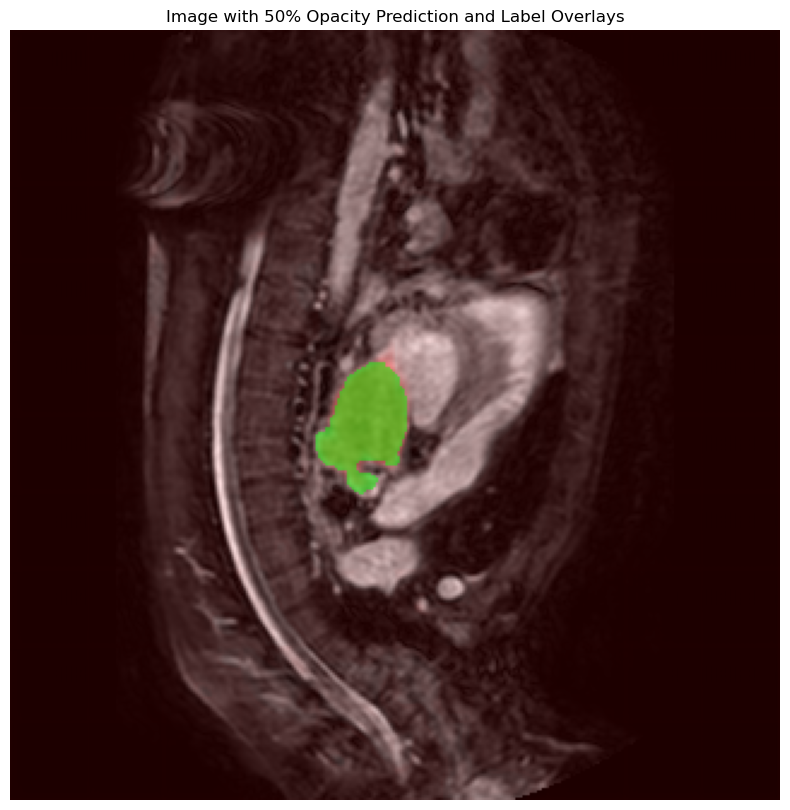

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 50
image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

# Normalize image slice for visualization (if needed)
image_slice = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())

# Create an RGB image from the grayscale slice
image_rgb = np.stack([image_slice]*3, axis=-1)

# Create solid colors for the prediction and label overlays
red_overlay = np.zeros_like(image_rgb)
red_overlay[..., 0] = 1  # Red color for prediction

green_overlay = np.zeros_like(image_rgb)
green_overlay[..., 1] = 1  # Green color for label

# Create the prediction and label masks (expanding dims for compatibility)
pred_mask = np.expand_dims(pred_slice, axis=-1)
label_mask = np.expand_dims(label_slice, axis=-1)

# Set the opacity for the overlays (50% opacity)
opacity = 0.5

# Blend the solid color with the original image using the mask
# First, apply the red overlay for predictions
overlay_image = image_rgb * (1 - pred_mask * opacity) + red_overlay * pred_mask * opacity

# Then, apply the green overlay for labels
overlay_image = overlay_image * (1 - label_mask * opacity) + green_overlay * label_mask * opacity

# Plot the resulting image with the 50% opacity overlays
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title('Image with 50% Opacity Prediction and Label Overlays')
plt.axis('off')
plt.show()
